<a href="https://colab.research.google.com/github/RhondaFischer/CTILGrowth/blob/main/bertopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install bertopic

In [4]:
#from sklearn.datasets import fetch_20newsgroups
#docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [3]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
#topics, probs = topic_model.fit_transform(docs)

In [ ]:
topic_model.get_topic(1)  # Select the most frequent topic

[('key', 0.014430890739897492),
 ('clipper', 0.012698513863868152),
 ('chip', 0.012017825425060526),
 ('encryption', 0.01167272808927951),
 ('keys', 0.009879145093081635),
 ('escrow', 0.008563502806160913),
 ('government', 0.008226895966737287),
 ('nsa', 0.007752657346139466),
 ('algorithm', 0.0069187423813012105),
 ('be', 0.00641445114812385)]

In [ ]:
docs[0]

"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [4]:
from bertopic import BERTopic
import pandas as pd
import numpy as np
import requests
import time
import pytz
import tweepy
from datetime import datetime, timedelta
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import string

import re

from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS 
from collections import Counter


import matplotlib.pyplot as plt
%matplotlib inline
string.punctuation

stopWords = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
TWITTER_KEY = 'caEYcNtnPofRcenQSdM1JOA0m'
TWITTER_SECRET = 'XaPN2dNmwx1IrNRy9Llxk35nuzrnG7LP2WmXqdOdLa5gSuKuA8'
TWITTER_BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAANmKVgEAAAAAJdfpUcZi7yJvFogOs921hxiwf20%3DhEzpHFtEBzwTj1rOJXbr2H8R2VAUJlr5HEhdcDkVvS95JXiiIO'
ACCESS_TOKEN = "173821067-MNagHLwNa20HBNSJuTDAYQQrvKlaARk51UWGjDps"
ACCESS_TOKEN_SECRET = "HhR6Lprg5ocs8cDqIZAmbAbef5VXK1z7SBeFLMR0ivyDe"

In [6]:
def get_tweepy_api():
    auth = tweepy.OAuthHandler(TWITTER_KEY, TWITTER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
    return tweepy.API(auth, wait_on_rate_limit=True, retry_count=10, retry_delay=3)

def get_tweepy_client():
    return tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, consumer_key=TWITTER_KEY, consumer_secret=TWITTER_SECRET, access_token=ACCESS_TOKEN, access_token_secret=ACCESS_TOKEN_SECRET, wait_on_rate_limit=True)

api = get_tweepy_api()

In [7]:
month_dict = {'Jan':'1', 'Feb':'2', 'Mar':'3', 'Apr':'4', 'May':'5', 'Jun': '6', 
              'Jul': '7', 'Aug': '8', 'Sep': '9', 'Oct':'10', 'Nov':'11', 'Dec':'12' }
day_of_week = {'Sun':'1', 'Mon':'2', 'Tue':'3', 'Wed': '4', 'Thu': '5', 'Fri':'6', 'Sat':'7'}
def process_lumin_tweet(status,is_retweeted):
    
    
    try:
        status = status._json
    except AttributeError as error:
        pass
    
    #tweet_data = {}
    tweet_data = pd.DataFrame(columns = [col_names])
    try:
        tweet_text = (status["extended_tweet"]["full_text"]).strip().replace('\n', ' ').replace('\r', '').replace(',', '').replace(u'’', u"'")
        is_extended=True
    except KeyError:
        tweet_text = (status["full_text"]).strip().replace('\n', ' ').replace('\r', '').replace(',', '').replace(u'’', u"'")
        is_extended=False
        
    tweet_id = str(status["id"])
    created_at = status["created_at"]
    tweet_yr = created_at[-4:-1]+created_at[-1]
    tweet_mo = created_at[4:7]
    tweet_mo_nbr = month_dict[tweet_mo]
    tweet_day = created_at[8:10]
    tweet_day_of_week = created_at[0:3]
    tweet_dow_nbr = day_of_week[tweet_day_of_week]
    tweet_hr = created_at[11:13]
    s = "-"
    seq = (tweet_yr, tweet_mo_nbr, tweet_day)
    tweet_date = s.join(seq)
    is_extended_tweet = is_extended
    is_retweet = is_retweeted
    is_quote_tweet = hasattr(status, "quoted_status")
    lang = status["lang"]
    
    if is_extended:
        url_count = len(status["extended_tweet"]["entities"]["urls"])
        hashtag_count = len(status["extended_tweet"]["entities"]["hashtags"])
    else:
        url_count = len(status["entities"]["urls"])
        hashtag_count = len(status["entities"]["hashtags"])
    
    user_json = status["user"]
    
    user_id = str(user_json["id"])
    screen_name = user_json["screen_name"]
    link_to_tweet = "https://twitter.com/{}/status/{}".format(tweet_data["screen_name"], status["id"])
    followers_count = user_json["followers_count"]
    friends_count = user_json["friends_count"]
    user_created_at = user_json["created_at"]
    user_statuses_count = user_json["statuses_count"]
    user_age_days = ((datetime.utcnow().replace(tzinfo=pytz.utc) - datetime.strptime(user_json['created_at'], "%a %b %d %H:%M:%S %z %Y")).days)
    try:
        tweets_per_day = user_json['statuses_count'] / user_age_days
    except ZeroDivisionError:
        tweets_per_day = 0
    user_tweets_per_day = tweets_per_day
    user_age_days = user_age_days
    
    retweet_count = status["retweet_count"]
    favorite_count = status["favorite_count"]
    rechecked_time = ((datetime.utcnow().replace(tzinfo=pytz.utc)))
    
    tweet_list = [tweet_text,
                  tweet_id,
                  created_at,
                  tweet_yr,
                  tweet_mo,
                  tweet_mo_nbr,
                  tweet_day,
                  tweet_hr,
                  tweet_day_of_week,
                  tweet_dow_nbr,
                  tweet_date,
                 is_extended_tweet,
                 is_retweet,
                 is_quote_tweet,
                 url_count,
                 hashtag_count,
                 lang,
                 user_id,
                 screen_name,
                 link_to_tweet,
                 followers_count,
                 friends_count,
                 user_created_at,
                 user_statuses_count,
                 user_tweets_per_day,
                 user_age_days,
                 retweet_count,
                 favorite_count,
                 rechecked_time]
    #print("tweet_list", tweet_list)

    return tweet_list


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
%cd /content/drive/MyDrive/TwitterLuminaries/

/content/drive/MyDrive/TwitterLuminaries


In [18]:
lumin=pd.read_csv("INcongressRep_luminary.csv")
lumin.columns=['handle']

In [19]:
lumin_list=list(lumin['handle'])
tweet_results_df = {
    'tweet_text': [], 'tweet_id': [], 'created_at': [], 'tweet_yr': [], 'tweet_mo':[], 'tweet_mo_nbr':[],
    'tweet_day': [], 'tweet_hr': [],'tweet_day_of_week':[] ,'tweet_dow_nbr':[], 'tweet_date': [], 'is_extended_tweet': [],
    'is_retweet': [], 'is_quote_tweet': [], 'url_count': [], 'hashtag_count': [], 'lang': [],
    'user_id': [], 'screen_name': [], 'link_to_tweet': [], 'followers_count': [],
    'friends_count': [], 'user_created_at': [], 'user_statuses_count': [], 'user_tweets_per_day': [],
    'user_age_days': [], 'retweet_count': [], 'favorite_count': [], 'rechecked_time': []
}

col_names = list(tweet_results_df.keys())

In [20]:
# adapting code from https://fairyonice.github.io/extract-someones-tweet-using-tweepy.html
# for each luminari, collect all their tweets and save in a dataframe
# limited to first 5 as a trial run
cnt = 0
tweet_result_df =pd.DataFrame(columns=[col_names])
for lumin in lumin_list:
    temp_list=[]
    print(lumin, cnt)
    cnt+=1
    
    # initial 200 tweets and set oldest_id
    tweets = api.user_timeline(screen_name=lumin, 
                           # 200 is the maximum allowed count
                            # 129 * 2 = 258 Luminati
                           count=129,
                           include_rts = False,
                           # Necessary to keep full_text 
                           # otherwise only the first 140 words are extracted
                           tweet_mode = 'extended'
                           )
    '''
    client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN)

    # Replace with your own search query
    query = 'from:suhemparack -is:retweet'
    tweets = client.search_all_tweets(query=query, tweet_fields=['context_annotations', 'created_at'],
                                  start_time=start_time,
                                  end_time=end_time, max_results=200)

    
    tweets = tw.Cursor(api.search,
                       q=new_search,
                       lang="en",
                       since=date_since).items(5)
    
    '''
    all_tweets = []
    all_tweets.extend(tweets)
    oldest_id = tweets[-1].id
    
    # continue for the next 200 as long as new tweets are returned
    while True:
        tweets = api.user_timeline(screen_name=lumin, 
                               # 200 is the maximum allowed count
                                   # 129 * 2 = 258 Luminati
                               count=129,
                               include_rts = False,
                               max_id = oldest_id - 1,
                               # Necessary to keep full_text 
                               # otherwise only the first 140 words are extracted
                               tweet_mode = 'extended'
                               )
        if len(tweets) == 0:
            break
        oldest_id = tweets[-1].id
        all_tweets.extend(tweets)
        #print('N of tweets downloaded till now {}'.format(len(all_tweets)))
        
    for tweet in all_tweets:
        temp_list.append(process_lumin_tweet(tweet,is_retweeted=False))
    df = pd.DataFrame(temp_list, columns=[col_names])
    tweet_result_df = pd.concat([tweet_result_df, df])
    print("N of tweets downloaded", len(all_tweets))
    

Jim_Banks 0
N of tweets downloaded 1969
RepJimBanks 1
N of tweets downloaded 2602
TeamJimBanks 2
N of tweets downloaded 232
RepJimBaird 3
N of tweets downloaded 856
RepGregPence 4
N of tweets downloaded 1285
RepTrey 5
N of tweets downloaded 636
RepLarryBucshon 6
N of tweets downloaded 2354
RepWalorski 7
N of tweets downloaded 2604
RepSpartz 8
N of tweets downloaded 651


In [21]:
len(tweet_result_df)

13189

In [22]:
#tweet_result_df['tweet_yr'] = pd.to_numeric(tweet_result_df['tweet_yr'])
tweet_result_df['tweet_yr'] = tweet_result_df['tweet_yr'].apply(pd.to_numeric)
tweet_result_df['tweet_yr'].describe()

,tweet_yr
count,13189.000000
mean,2019.183638
std,2.141230
min,2013.000000
25%,2018.000000
50%,2020.000000
75%,2021.000000
max,2022.000000


In [23]:
# Filter out tweets from older than 2020
tweet_result_df = tweet_result_df.loc[np.array(tweet_result_df['tweet_yr']) > 2020.0]

len(tweet_result_df)

4951

In [24]:
tweet_result_df.to_csv("full_INreps_lumin_tweets.csv")

In [25]:
tweet_result_df2 = pd.read_csv("full_INreps_lumin_tweets.csv")

In [26]:
X = tweet_result_df2.copy()

In [27]:
X.columns = X.columns.get_level_values(0)

In [28]:
# creating a function to encapsulate EDA/preprocessing
# Take a dataframe as input and return DF as output
# Add new numerical features to the dataframe (e.g., number of words in the string)
#
def textPreprocessing(df):
    #lowercase the text strings and remove punctuation
    # store in a new column
    df['processed'] = df['tweet_text'].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))  #\w [a-zA-Z0-9_] \s [ \t\n\r\f\v]
    
    # numerical feature engineering
    # total length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    # get number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    # get the average word length
    df['avg_word_length'] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    # get the sum(map(text.count, string.punctuation))/len(text)
    df['punctuationRatio'] = df['tweet_text'].apply(lambda x: sum(map(x.count, string.punctuation))/len(x))
    df['commas'] = df['tweet_text'].apply(lambda x: x.count(','))

    return(df)  # return a dataframe for now

#datasets["train"] = textPreprocessing(datasets["train"])
#datasets["train"].head()

In [29]:
tweetset = textPreprocessing(X)

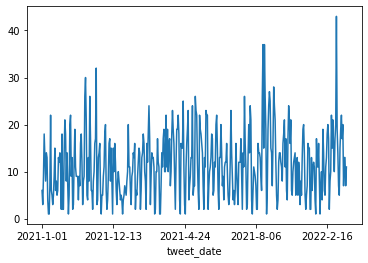

In [30]:
tweetset.groupby(by='tweet_date').size().plot()

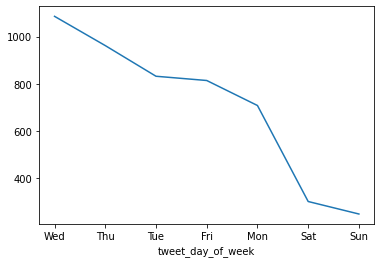

In [31]:
tweetset.groupby(by='tweet_day_of_week').size().sort_values(ascending = False).plot()

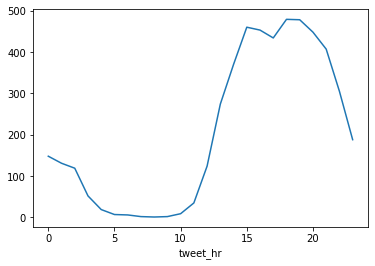

In [32]:
tweetset.groupby(by='tweet_hr').size().plot()

In [33]:
numeric_features = ['url_count', 'hashtag_count','followers_count', 'friends_count',
                    'user_tweets_per_day','user_age_days', 'retweet_count',
                    'favorite_count',
                    'length', 'words', 'words_not_stopword', 'avg_word_length', 
                    'punctuationRatio', 'commas']
text_features = ['processed']
categorical_features = ['is_retweet', 'tweet_day_of_week']

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer
import re
from sklearn.compose import ColumnTransformer

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values  #return a Numpy Array to observe the pipeline protocol

In [36]:
# We create the preprocessing pipelines for both numeric and categorical data.
max_words = 500

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

text_pipeline = Pipeline([
                ('selector', DataFrameSelector('processed')),
                #('tfidf', TfidfVectorizer( stop_words='english')),
                ('tfidf', TfidfVectorizer( norm=None, analyzer='word',
                           max_features=max_words,
                           ngram_range = (1,1),
                            stop_words='english',
                            #stop_words = my_stop_words,
                            #tokenizer=tokenize,
                            use_idf = True,
                           ))
                #('dense', sparse_to_dense())
            ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('txt', text_pipeline, text_features)
    ], 
    remainder='drop',
    n_jobs=-1)


In [37]:
X_transformed_sparse = preprocessor.fit_transform(tweetset)
X_transformed_dense = X_transformed_sparse.toarray()

#print(preprocessor.transformers_[1][1])
#print(preprocessor.transformers_[2][1].named_steps["tfidf"].get_feature_names())

column_names1 = numeric_features  + list(preprocessor.transformers_[1][1].named_steps["onehotencoder"].get_feature_names_out(categorical_features))
column_names2 = list(preprocessor.transformers_[2][1].named_steps["tfidf"].get_feature_names_out())
column_names = column_names1+column_names2
print("number of columns:", len(column_names))
display(pd.DataFrame(X_transformed_dense,  columns=column_names).head())
number_of_inputs = X_transformed_dense.shape[1]
dense_df = pd.DataFrame(X_transformed_dense,  columns=column_names)
print("Total Rows:",len(dense_df), "Columns:", len(dense_df.columns))

number of columns: 522


,url_count,hashtag_count,followers_count,friends_count,user_tweets_per_day,user_age_days,retweet_count,favorite_count,length,words,...,workers,workforce,working,world,worst,wrong,year,years,yesterday,young
0,-0.927413,-0.418409,-0.682281,1.857168,-0.670446,2.489275,-0.179810,-0.200522,-1.904653,-1.893986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.031470,-0.418409,-0.682281,1.857168,-0.670446,2.489275,-0.144867,-0.168007,-0.982671,-0.865408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.927413,-0.418409,-0.682281,1.857168,-0.670446,2.489275,-0.179810,-0.199709,-1.542863,-1.591463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.031470,-0.418409,-0.682281,1.857168,-0.670446,2.489275,-0.163682,-0.187516,-1.052695,-0.865408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.031470,-0.418409,-0.682281,1.857168,-0.670446,2.489275,-0.126051,-0.152563,-0.247420,-0.018343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Rows: 4951 Columns: 522


In [38]:
dense_df['screen_name']=tweetset['screen_name'].copy()

In [39]:
dense_df['words_not_stopword'].mean()

1.9688463252290194e-17

In [40]:
def create_nmf_df(number_of_topics, features_per_topic, fitted_corpus, source, word_list):

    #nmf = NMF(n_components=number_of_topics, solver="mu")
    #nmf = NMF(n_components=number_of_topics, random_state=1, alpha=.1, l1_ratio=.5)
    nmf = NMF(n_components=number_of_topics, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha_W=.1,l1_ratio=.5)
    
    
    W = nmf.fit_transform(fitted_corpus)
    H = nmf.components_
    nmf_list = []

    for i, topic in enumerate(H):
        print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in word_list[topic.argsort()[-features_per_topic:]]])))
        #print(-number_of_topics)
        top_features_ind = topic.argsort()[:-number_of_topics - 1:-1]

In [41]:
def create_tf_df(max_words, tf_corpus, source):
    
    print("**** tf *******")

    tf_vect = CountVectorizer(max_df=0.95, min_df=2,
                                    analyzer='word',
                                    max_features=max_words,
                                    ngram_range = (1,1),
                                    tokenizer=tokenize
                                    )
    tf_fit_vec = tf_vect.fit(tf_corpus)
    tf = tf_fit_vec.transform(tf_corpus)

    # create an array of the names
    tf_words = np.array(tf_vect.get_feature_names_out())
    print("length of tf_words", len(tf_words))

    # sort the words by top frequency
    sum_tf = tf.sum(axis=0)
    words_tf = [(word, sum_tf[0, idx]) for word, idx in tf_fit_vec.vocabulary_.items()]
    words_tf =sorted(words_tf, key = lambda x: x[1], reverse=True)
    
    # create a data frame with graph headings and print the header 
    tf_df = pd.DataFrame(words_tf[0:50], columns = [["Token", "Count"]])
    tf_df = tf_df[['Token','Count']]
    print(tf_df.head(25), "\n")
    
    # create tf word cloud
    words = tf_df['Token'].to_numpy()
    words = list(words.T)
    listToStr = ' '.join([elem for elem in words[0]])
    wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = my_stop_words, 
                min_font_size = 10).generate(listToStr) 
    
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

    
    return tf_df, tf, tf_words

# tf_df, tf = create_tf_df(100000,all_corpus['IsraelNAS'])

In [42]:
# functions for tokenizing the tweets, removing stop words, including key words
# using reg expressions to remove website and hashtag strings (starting with http and #)
# only using text characters and character strings with lengths between 2 and 20 characters

my_stop_words = text.ENGLISH_STOP_WORDS.union(["https", "http", "amp", "like","ll", "ve",
                                              "theyr", "isnt", "dont", "just", "that"])

def wordsToList(strn):
    L = strn.split()
    #pat1 = r'@[A-Za-z0-9_]+'
    pat2 = r'@[\w]+'
    pat3 = r'https?://[^ ]+'
    pat4 = r'#[^ ]+'    
    combined_pat = r'|'.join((pat2,pat3,pat4))
    cleanL = []
    for e in L:
        word = ''
        stripped = re.sub(combined_pat, '', e)
        letters_only = re.sub("[^a-zA-Z]",'', stripped)
        if len(letters_only)>1 and len(letters_only) <20:          
            cleanL.append(letters_only.lower())
    return cleanL

stemmer = PorterStemmer()
def tokenize(text):
        tokens = wordsToList(text)
        words = [x for x in tokens if x not in my_stop_words]
        #stems = [stemmer.stem(item) for item in words]
        return words

#my_stop_words

**** tf *******
length of tf_words 500
        Token Count
0       biden   975
1       today   485
2   democrats   426
3    american   413
4   americans   370
5   president   361
6     indiana   301
7       great   297
8         joe   281
9    hoosiers   278
10     border   275
11    america   267
12       work   267
13     people   266
14      house   254
15     crisis   220
16        day   209
17       year   208
18    country   206
19     nation   204
20       time   203
21        act   202
22    working   200
23       life   199
24   families   197 



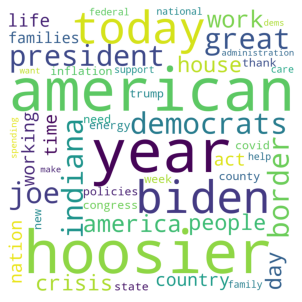

creating tf nmf weights
Topic 1: american, americans, president, democrats, biden
Topic 2: hoosiers, work, indiana, great, today
Topic 3: budget, debt, lie, tax, democrats
Topic 4: crisis, humanitarian, bidenbordercrisis, border, southern
Topic 5: freedom, free, forward, good, young
Topic 6: unborn, pro, hyde, abortion, life
Topic 7: freedom, free, foreign, young, agree
Topic 8: win, communist, big, tech, twitter
Topic 9: free, good, birthday, happy, twitter
Topic 10: elections, speakerpelosi, floor, vote, election
Topic 11: heroes, men, birthday, god, veterans
Topic 12: freedom, free, forward, good, young


In [43]:
# dense_df.sample(frac=0.05)
'''
X_train = sample_df.copy()
y_train = sample_df['y3'].copy()
X_train = X_train.drop(columns=['y3','y10'])
'''

tf_df, tf, tf_words = create_tf_df(500, X['processed'], "twitter")

print("creating tf nmf weights")
nmf_tf_df = create_nmf_df(12, 5, tf, "lumin", tf_words)

In [44]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
#JBtopics, JBprobs = topic_model.fit_transform(tf_words)
JBtopics, JBprobs = topic_model.fit_transform(X['processed'])

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

2022-03-16 17:52:30,986 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-03-16 17:53:10,920 - BERTopic - Reduced dimensionality with UMAP
2022-03-16 17:53:12,574 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [45]:
freq = topic_model.get_topic_info(); freq.head(12)

,Topic,Count,Name
0,-1,1167,-1_the_and_to_of
1,0,335,0_https_co_you_congrats
2,1,279,1_biden_joe_president_his
3,2,227,2_inflation_spending_democrats_tax
4,3,210,3_border_crisis_southern_illegal
5,4,165,4_china_ccp_chinese_communist
6,5,131,5_farmers_agriculture_indiana_hoosier
7,6,123,6_afghanistan_taliban_biden_withdrawal
8,7,101,7_election_elections_voter_vote
9,8,94,8_ukraine_putin_russian_russia


-1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated:

In [46]:
topic_model.get_topic(28)  # Select the most frequent topic

[('parents', 0.09943331819651673),
 ('school', 0.03723309627038362),
 ('kids', 0.032350525852303684),
 ('nsbapubliced', 0.03040624749356282),
 ('crt', 0.02923975947032227),
 ('garland', 0.028627959097649872),
 ('letter', 0.021946517020803514),
 ('patriot', 0.0212487083433523),
 ('board', 0.021232389542938098),
 ('taught', 0.02010188139927418)]

In [47]:
topic_model.get_topic(10)  # Select the most frequent topic

[('happy', 0.06478878412508485),
 ('christmas', 0.046559978690091534),
 ('wishing', 0.04277266784951891),
 ('blessed', 0.03398016788233743),
 ('family', 0.03319886753182703),
 ('wish', 0.03224093663794415),
 ('yours', 0.032198071055016146),
 ('all', 0.031107041383384895),
 ('merry', 0.029843833628077795),
 ('mother', 0.027184134305869943)]

In [48]:
topic_model.visualize_topics()

In [50]:
topic_model.visualize_distribution(JBprobs[200], min_probability=0.005)

In [51]:
topic_model.visualize_hierarchy(top_n_topics=30)

In [52]:
topic_model.visualize_barchart(top_n_topics=20)

In [53]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [54]:
topic_model.visualize_term_rank()

In [55]:
topic_model.update_topics(X['processed'], JBtopics, n_gram_range=(1, 2))

In [56]:
topic_model.get_topic(10)   # We select topic that we viewed before

[('happy', 0.03994847758541723),
 ('christmas', 0.026839535529616217),
 ('wishing', 0.02493252484239941),
 ('all', 0.020939560613099227),
 ('family', 0.02087592028202074),
 ('blessed', 0.01937025166051995),
 ('wish', 0.01894811047522894),
 ('you', 0.018720415817148003),
 ('to yours', 0.018569813437845525),
 ('and your', 0.018449986846984793)]

In [59]:
new_topics, new_probs = topic_model.reduce_topics(X['processed'], JBtopics, JBprobs, nr_topics=60)

2022-03-16 17:57:48,477 - BERTopic - Reduced number of topics from 79 to 61


In [60]:
similar_topics, similarity = topic_model.find_topics("tech", top_n=5); similar_topics

[12, 39, 48, 25, 31]

In [61]:
# Save model
topic_model.save("INreps_model")

In [ ]:
# Load model
my_model = BERTopic.load("INreps_model")	